In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet import Prophet

# Load the dataset
file_path = 'data/monatszahlen2405_verkehrsunfaelle_export_31_05_24_r.csv'
data = pd.read_csv(file_path)

In [16]:
# Filter for the relevant category and type
filtered_data = data[
    (data['MONATSZAHL'] == 'Alkoholunfälle') &
    (data['AUSPRAEGUNG'] == 'insgesamt') &
    (data['JAHR'] <= 2020)
]
filtered_data = filtered_data[['JAHR', 'MONAT', 'WERT']].dropna()

# Remove summary rows and convert month to datetime
filtered_data = filtered_data[filtered_data['MONAT'] != 'Summe']
filtered_data['MONTH'] = pd.to_datetime(filtered_data['JAHR'].astype(str) + filtered_data['MONAT'].str[-2:], format='%Y%m')
filtered_data = filtered_data[['MONTH', 'WERT']].set_index('MONTH').sort_index()

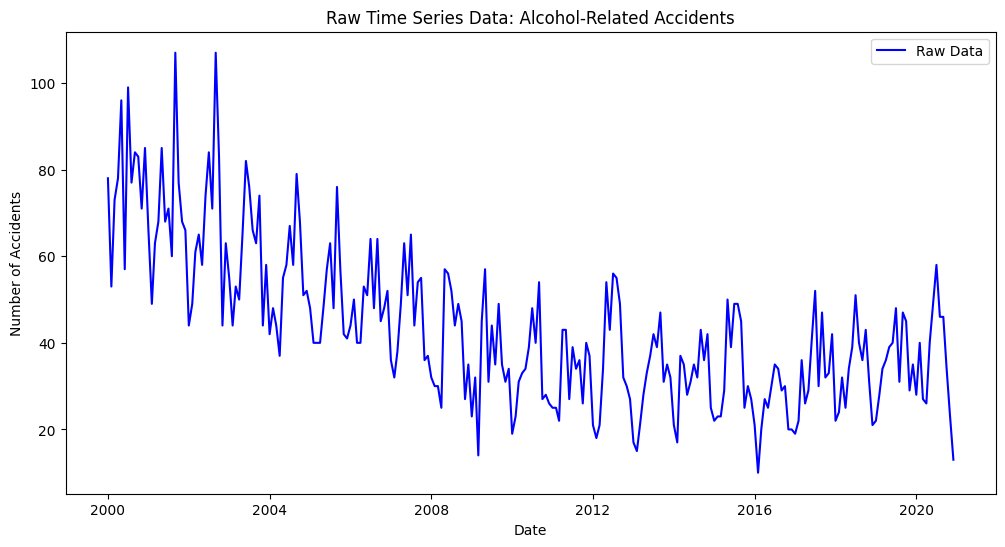

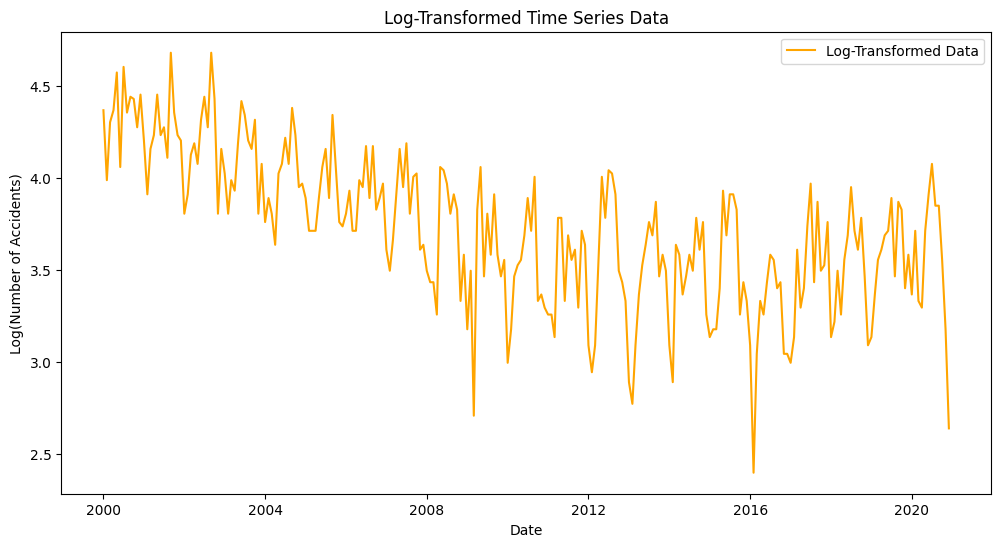

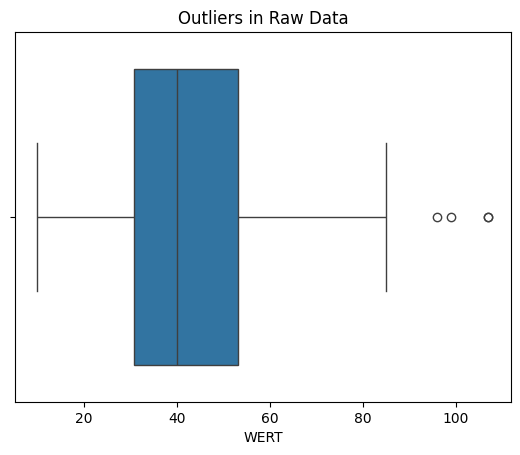

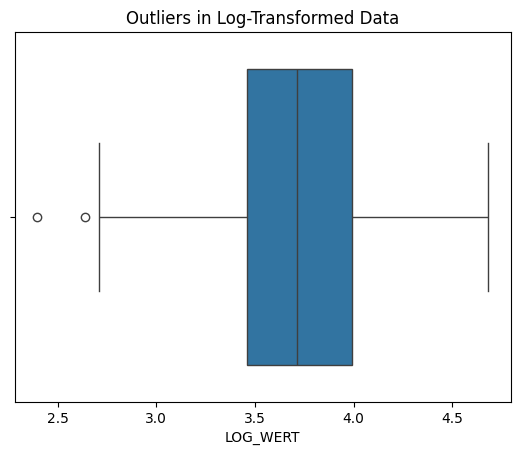

In [17]:
# EDA: Plot raw data
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['WERT'], label='Raw Data', color='blue')
plt.title("Raw Time Series Data: Alcohol-Related Accidents")
plt.xlabel("Date")
plt.ylabel("Number of Accidents")
plt.legend()
plt.show()

# Apply log transformation
filtered_data['LOG_WERT'] = np.log1p(filtered_data['WERT'])
plt.figure(figsize=(12, 6))
plt.plot(filtered_data['LOG_WERT'], label='Log-Transformed Data', color='orange')
plt.title("Log-Transformed Time Series Data")
plt.xlabel("Date")
plt.ylabel("Log(Number of Accidents)")
plt.legend()
plt.show()

# Visualize outliers
sns.boxplot(x=filtered_data['WERT'])
plt.title("Outliers in Raw Data")
plt.show()

sns.boxplot(x=filtered_data['LOG_WERT'])
plt.title("Outliers in Log-Transformed Data")
plt.show()

In [18]:
# Prepare for comparison
results = []

# ARIMA on raw data
model_raw = ARIMA(filtered_data['WERT'], order=(1, 1, 1))
fitted_model_raw = model_raw.fit()
forecast_raw = fitted_model_raw.get_forecast(steps=1)
forecast_value_raw = forecast_raw.predicted_mean.iloc[0]
results.append({"Model": "ARIMA (Raw)", "Forecast": forecast_value_raw})

# ARIMA on log-transformed data
model_log = ARIMA(filtered_data['LOG_WERT'], order=(1, 1, 1))
fitted_model_log = model_log.fit()
forecast_log = fitted_model_log.get_forecast(steps=1)
forecast_value_log = np.expm1(forecast_log.predicted_mean.iloc[0])  # Reverse log transformation
results.append({"Model": "ARIMA (Log)", "Forecast": forecast_value_log})

# Auto-ARIMA on raw data
auto_arima_raw = auto_arima(
    filtered_data['WERT'], 
    seasonal=False, 
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True
)
forecast_auto_raw = auto_arima_raw.predict(n_periods=1)[0]
results.append({"Model": "Auto-ARIMA (Raw)", "Forecast": forecast_auto_raw})

# Auto-ARIMA on log-transformed data
auto_arima_log = auto_arima(
    filtered_data['LOG_WERT'], 
    seasonal=False, 
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True
)
forecast_auto_log = np.expm1(auto_arima_log.predict(n_periods=1)[0])  # Reverse log transformation
results.append({"Model": "Auto-ARIMA (Log)", "Forecast": forecast_auto_log})

# Auto-ARIMA with seasonality on log-transformed data
auto_arima_seasonal = auto_arima(
    filtered_data['LOG_WERT'], 
    seasonal=True, 
    m=12,  # Monthly seasonality
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True
)
forecast_seasonal_log = np.expm1(auto_arima_seasonal.predict(n_periods=1)[0])
results.append({"Model": "Auto-ARIMA (Seasonal Log)", "Forecast": forecast_seasonal_log})

# Prophet model
prophet_data = filtered_data.reset_index().rename(columns={"MONTH": "ds", "WERT": "y"})
prophet_model = Prophet()
prophet_model.fit(prophet_data)
future = prophet_model.make_future_dataframe(periods=1, freq='M')
forecast_prophet = prophet_model.predict(future)
forecast_value_prophet = forecast_prophet.iloc[-1]['yhat']
results.append({"Model": "Prophet", "Forecast": forecast_value_prophet})

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.f

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1927.066, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1997.543, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1959.851, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1956.164, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1995.645, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1960.127, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1925.567, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1927.558, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1958.829, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1925.646, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1960.820, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1929.547, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1927.933, Time=0.03 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 0.638 seconds
Performing stepwise se

/var/folders/6l/rd9mz6093d1688p05vb4jvk80000gn/T/ipykernel_69180/1323278409.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_auto_raw = auto_arima_raw.predict(n_periods=1)[0]


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=42.256, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=94.469, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=74.652, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=71.599, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=92.612, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=39.833, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=53.271, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=38.334, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=39.601, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=73.916, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=40.599, Time=0.02 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.458 seconds
Performing stepwise search to minimize aic


/var/folders/6l/rd9mz6093d1688p05vb4jvk80000gn/T/ipykernel_69180/1323278409.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_auto_log = np.expm1(auto_arima_log.predict(n_periods=1)[0])  # Reverse log transformation


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-54.801, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=94.469, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=40.363, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=47.367, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=92.612, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=17.424, Time=0.58 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-8.925, Time=0.50 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-57.876, Time=1.86 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-48.862, Time=2.27 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=-56.284, Time=2.81 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-58.997, Time=2.13 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=-11.663, Time=1.77 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=-59.747, Time=2.12 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=-14.175, Time=1.73 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-57.956, Time=0.55 sec
 ARIMA(1,1,2)(2,

/var/folders/6l/rd9mz6093d1688p05vb4jvk80000gn/T/ipykernel_69180/1323278409.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_seasonal_log = np.expm1(auto_arima_seasonal.predict(n_periods=1)[0])
16:54:15 - cmdstanpy - INFO - Chain [1] start processing


 ARIMA(2,1,2)(1,0,2)[12]             : AIC=-60.910, Time=1.51 sec

Best model:  ARIMA(1,1,1)(1,0,2)[12]          
Total fit time: 53.758 seconds


16:54:15 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


                       Model   Forecast  Ground Truth  Absolute Error  \
0                ARIMA (Raw)  25.622543          16.0        9.622543   
1                ARIMA (Log)  20.472689          16.0        4.472689   
2           Auto-ARIMA (Raw)  22.959208          16.0        6.959208   
3           Auto-ARIMA (Log)  19.571858          16.0        3.571858   
4  Auto-ARIMA (Seasonal Log)  20.953103          16.0        4.953103   
5                    Prophet  22.273038          16.0        6.273038   

   Percentage Error  
0         60.140892  
1         27.954303  
2         43.495051  
3         22.324113  
4         30.956891  
5         39.206488  


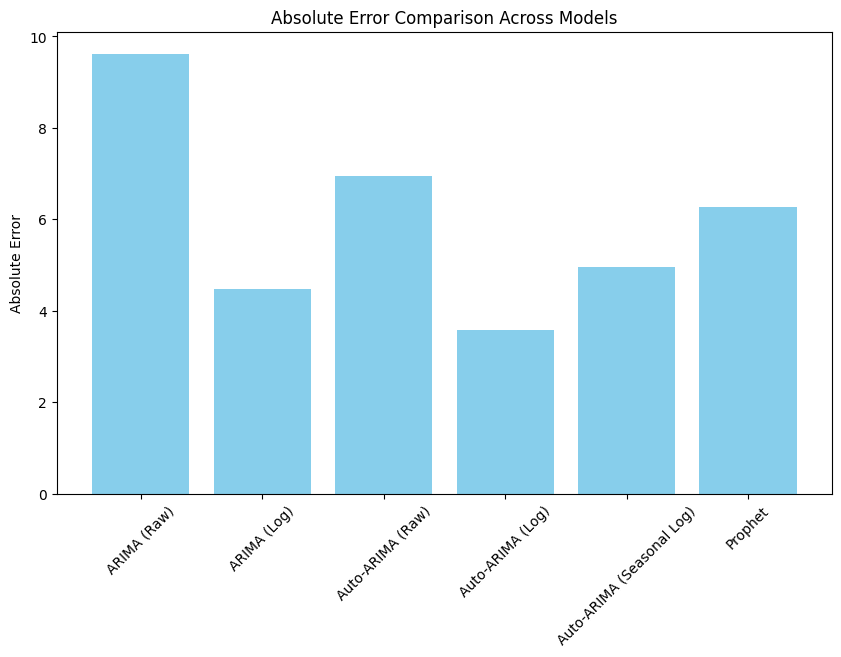

In [20]:
# Ground Truth
ground_truth = data[
    (data['MONATSZAHL'] == 'Alkoholunfälle') &
    (data['AUSPRAEGUNG'] == 'insgesamt') &
    (data['JAHR'] == 2021) &
    (data['MONAT'] == '202101')
]['WERT'].values

if len(ground_truth) > 0:
    ground_truth_value = ground_truth[0]
    for result in results:
        result["Ground Truth"] = ground_truth_value
        result["Absolute Error"] = abs(ground_truth_value - result["Forecast"])
        result["Percentage Error"] = (result["Absolute Error"] / ground_truth_value) * 100
else:
    for result in results:
        result["Ground Truth"] = None
        result["Absolute Error"] = None
        result["Percentage Error"] = None

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print(results_df)

# Visualize comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Absolute Error'], color='skyblue')
plt.title('Absolute Error Comparison Across Models')
plt.ylabel('Absolute Error')
plt.xticks(rotation=45)
plt.show()

Prophet isn't performing very well either. It's time to move to:
- Machine Learning
- LSTM